In [1]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, normalized_mutual_info_score

In [2]:
dataset = pd.read_csv("dataset/dataset.csv")
y = dataset['36']
X = dataset.drop(columns=['36'])
def remap_labels(labels):
    remap_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
    return [remap_dict[label] for label in labels]

remapped_labels = remap_labels(y.values)

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

In [4]:
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(np.array(remapped_labels).reshape(-1, 1))

C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [10]:
def voting_approach(som, dim, X, y):
    winner_map_voting = np.zeros(dim, dtype=int)
    for i, x in enumerate(X):
        win = som.winner(x)
        lable = np.argmax(y[i])
        winner_map_voting[win[0], win[1], lable] += 1
    neuron_labels = np.argmax(winner_map_voting, axis=2)
    plt.figure(figsize=(5, 4))
    plt.pcolor(neuron_labels, cmap='viridis')
    plt.colorbar()
    plt.title('Winner Map - Voting Approach')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return neuron_labels.flatten()

In [17]:
def Kmeans_approach(som, y, n_clusters):
    weights = som.get_weights()
    num_neurons = weights.shape[0] * weights.shape[1]
    flattened_weights = weights.reshape((num_neurons, -1))
#     n_clusters = y_train.shape[1]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init = 10)
    kmeans.fit(flattened_weights)
    neuron_labels = kmeans.labels_
    labels_grid = neuron_labels.reshape(weights.shape[0], weights.shape[1])
    plt.figure(figsize=(5, 4))
    plt.pcolor(labels_grid, cmap='viridis')
    plt.colorbar()
    plt.title('SOM Neuron Labels - K-means Approach')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return neuron_labels    

$$ DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d_{ij}} \right) $$

where:
- k is the number of clusters,
- $\sigma_i$ is the average distance of all points in cluster i to the centroid of cluster i,
- $d_{ij}$ is the distance between centroids of clusters i and j,
- The maximum is taken over all clusters $j \neq i$.
- A lower Davies-Bouldin score indicates a better clustering configuration,


$$ \text{NMI}(U, V) = \frac{2 \times \text{MI}(U, V)}{H(U) + H(V)} $$

Where:
-  U  and  V  are two different cluster assignments (e.g., the true labels and the predicted labels).
-  $\text{MI}(U, V) $ is the mutual information between  U  and  V .
-  H(U) and  H(V)  are the entropies of  U  and  V , which measure the uncertainty or randomness in the assignments.

In [93]:
def test_clusters(title, som, X,y, neuron_labels):
    winning_neurons = np.array([som.winner(x) for x in X])
    weights = som.get_weights()
    winning_indices = winning_neurons[:, 0] * weights.shape[1] + winning_neurons[:, 1]
    y_pred = neuron_labels[winning_indices]
    db_index = davies_bouldin_score(np.argmax(y, axis=1).reshape(-1, 1), y_pred)
    nmi = normalized_mutual_info_score(np.argmax(y, axis=1), y_pred)

    print(title)
    print(f"Davies-Bouldin Index: {db_index}")
    print(f"Normalized Mutual Information: {nmi}")
    return db_index, nmi

- If k is too small, sigma will be large, and the updates will be very global, possibly smoothing over local variations too much.
- If k is too large, sigma will be small, and the updates may be too localized, potentially leading to a lack of global order in the map.

In [133]:
sigma0 = np.sqrt((30 ** 2) + (30 ** 2)) // 10
print(sigma0)

4.0


In [158]:
som_30x30 = MiniSom(30, 30, X_train.shape[1], sigma=1, learning_rate=0.1, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=42)
som_30x30.train_batch(X_train, 10000)

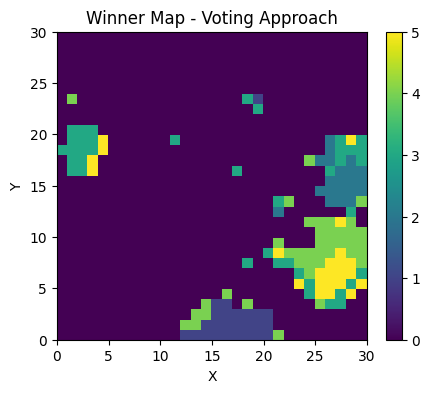

In [159]:
dim = (30, 30, y_train.shape[1])
neuron_labels = voting_approach(som_30x30, dim, X_train, y_train)

In [160]:
# voting_approach
dbi_voting = test_clusters("voting approach: ", som_30x30, X_train, y_train, neuron_labels)

voting approach: 
Davies-Bouldin Index: 0.8389689416471943
Normalized Mutual Information: 0.7465827169569506


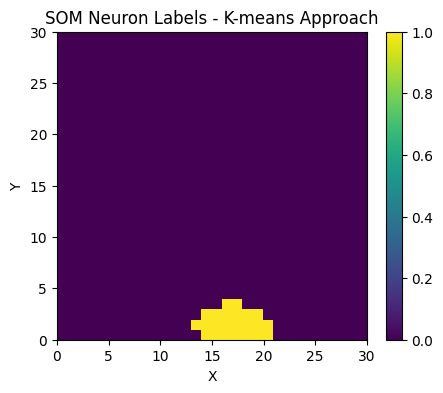

kmeans approach: 
Davies-Bouldin Index: 1.0005900611567884
Normalized Mutual Information: 0.30657150891045254
number of clusters:  2
------------------------------


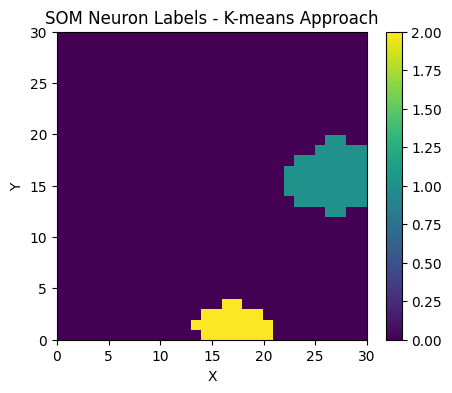

kmeans approach: 
Davies-Bouldin Index: 1.6484760979857203
Normalized Mutual Information: 0.42564818495808737
number of clusters:  3
------------------------------


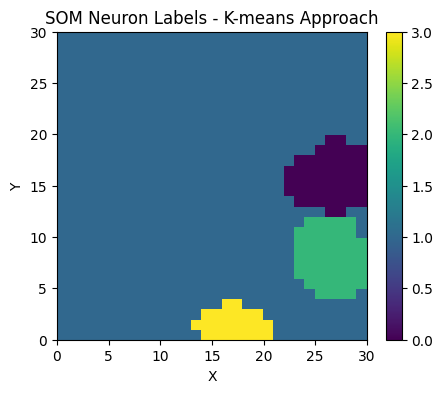

kmeans approach: 
Davies-Bouldin Index: 2.572144105210972
Normalized Mutual Information: 0.43829635382396875
number of clusters:  4
------------------------------


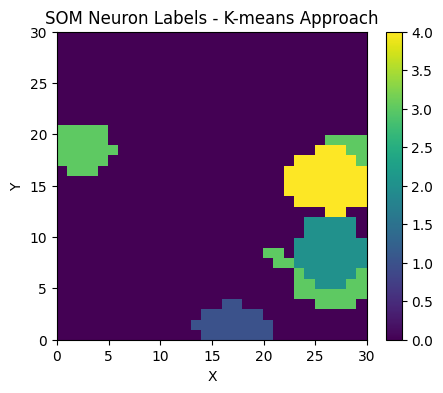

kmeans approach: 
Davies-Bouldin Index: 6.4094857786934565
Normalized Mutual Information: 0.5210372776756029
number of clusters:  5
------------------------------


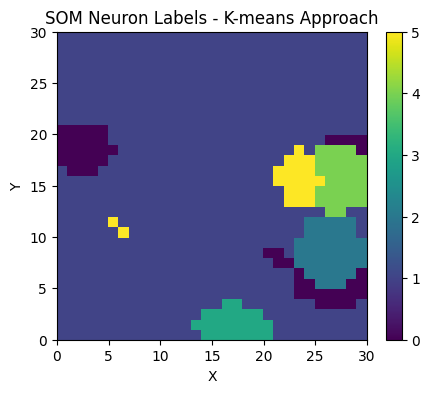

kmeans approach: 
Davies-Bouldin Index: 3.4455059198004427
Normalized Mutual Information: 0.584261010278621
number of clusters:  6
------------------------------


In [161]:
dbi_clusters = [] 
nmi_clusters = [] 
for n_clusters in range(2,7):
    neuron_labels = Kmeans_approach(som_30x30, y_train, n_clusters)
    dbi, nmi = test_clusters("kmeans approach: ", som_30x30, X_train, y_train, neuron_labels)
    dbi_clusters.append(dbi)
    nmi_clusters.append(nmi)
    print("number of clusters: ", n_clusters)
    print("------------------------------")
 

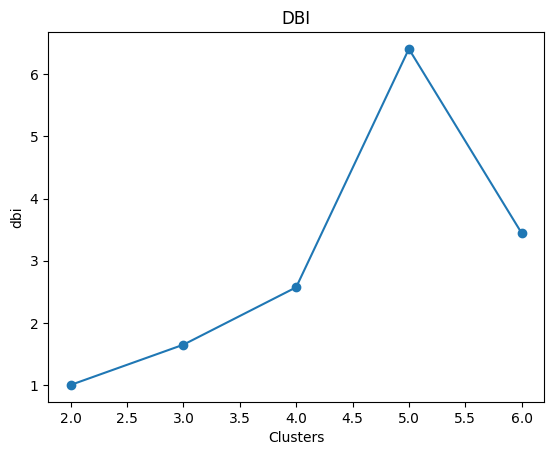

In [162]:
x = range(2, len(dbi_clusters) + 2)
plt.plot(x, dbi_clusters, marker='o')
plt.title('DBI')
plt.xlabel('Clusters')
plt.ylabel('dbi')
plt.show()

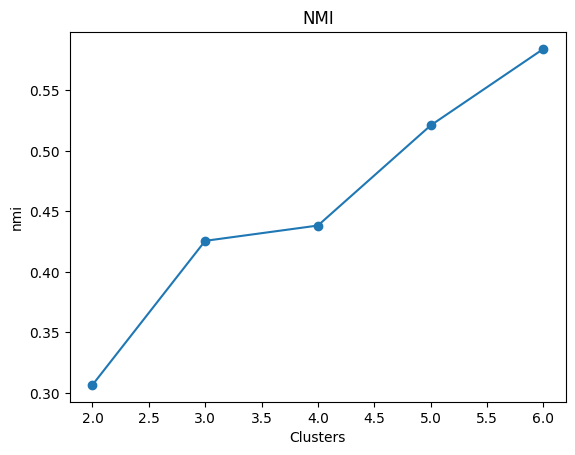

In [163]:
x = range(2, len(nmi_clusters) + 2)
plt.plot(x, nmi_clusters, marker='o')
plt.title('NMI')
plt.xlabel('Clusters')
plt.ylabel('nmi')
plt.show()

# Test

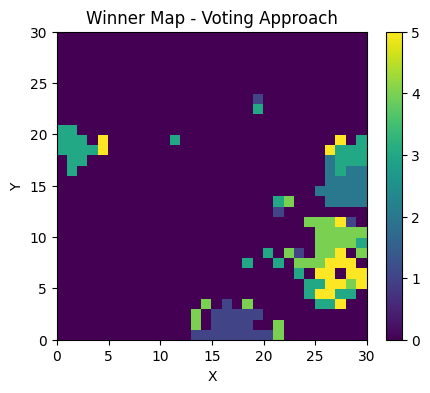

voting approach: 
Davies-Bouldin Index: 0.44759067702539057
Normalized Mutual Information: 0.8385520916158298


In [174]:
dim = (30, 30, y_train.shape[1])
neuron_labels = voting_approach(som_30x30, dim, X_test, y_test)
dbi_voting = test_clusters("voting approach: ", som_30x30, X_test, y_test, neuron_labels)

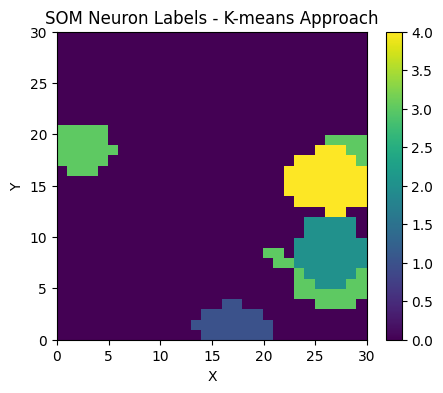

kmeans approach: 
Davies-Bouldin Index: 6.507660965359394
Normalized Mutual Information: 0.5279872191646374


In [175]:
neuron_labels = Kmeans_approach(som_30x30, y_train, 5)
dbi, nmi = test_clusters("kmeans approach: ", som_30x30, X_test, y_test, neuron_labels)

In [164]:
sigma0 = np.sqrt((20 ** 2) + (20 ** 2)) // 10
print(sigma0)

2.0


In [165]:
som_20x20 = MiniSom(20, 20, X_train.shape[1], sigma=sigma0, learning_rate=0.1, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=42)
som_20x20.train_batch(X_train, 1000)

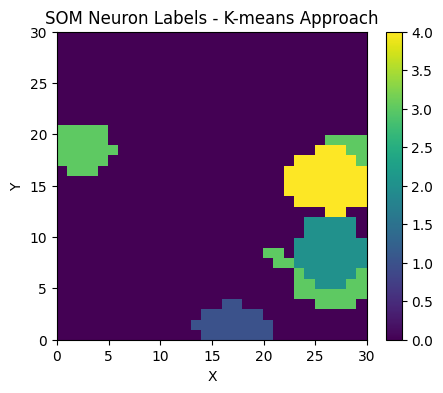

kmeans approach: 
Davies-Bouldin Index: 6.507660965359394
Normalized Mutual Information: 0.5279872191646374


In [175]:
neuron_labels = Kmeans_approach(som_30x30, y_train, 5)
dbi, nmi = test_clusters("kmeans approach: ", som_30x30, X_test, y_test, neuron_labels)

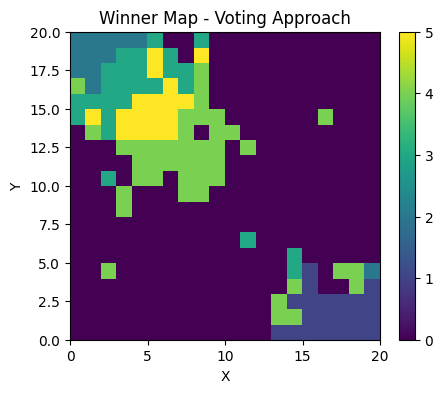

In [166]:
dim = (20, 20, y_train.shape[1])
neurons_label = voting_approach(som_20x20, dim, X_train, y_train)

C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


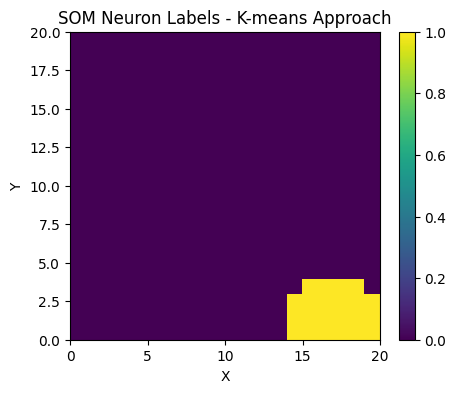

kmeans approach: 
Davies-Bouldin Index: 0.930865463494668
Normalized Mutual Information: 0.30269508394467914
number of clusters:  2
------------------------------


C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


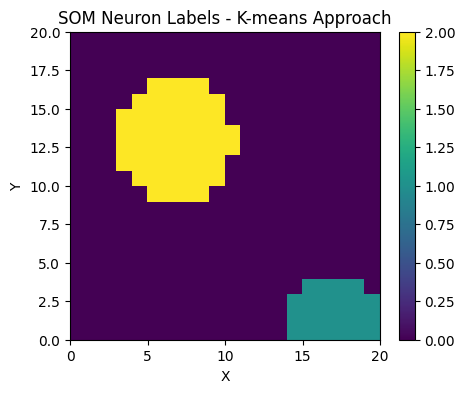

kmeans approach: 
Davies-Bouldin Index: 1.2119748952429532
Normalized Mutual Information: 0.4134925663313744
number of clusters:  3
------------------------------


C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


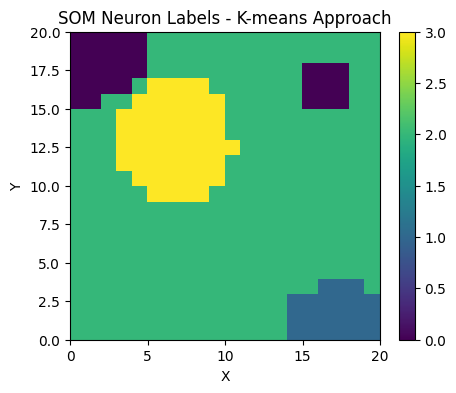

kmeans approach: 
Davies-Bouldin Index: 3.009229675177677
Normalized Mutual Information: 0.42897011346576863
number of clusters:  4
------------------------------


C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


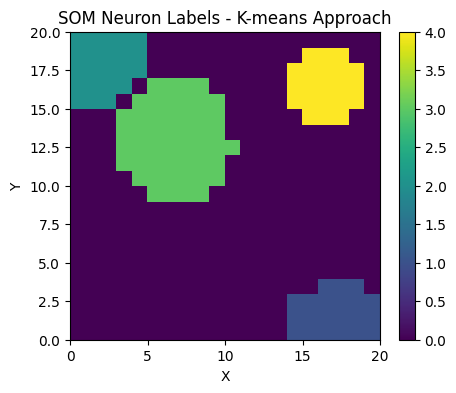

kmeans approach: 
Davies-Bouldin Index: 3.7201792275942425
Normalized Mutual Information: 0.5304419347797925
number of clusters:  5
------------------------------


C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


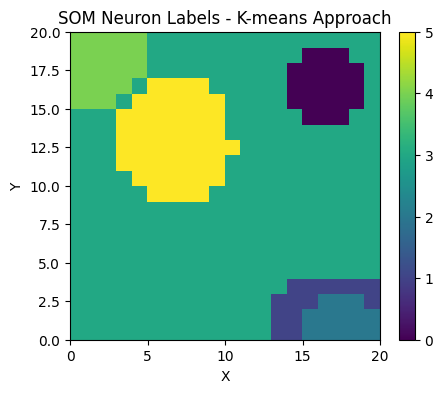

kmeans approach: 
Davies-Bouldin Index: 2.8999662519850413
Normalized Mutual Information: 0.5374312433580375
number of clusters:  6
------------------------------


In [169]:
dbi_clusters = [] 
nmi_clusters = [] 
for n_clusters in range(2,7):
    neuron_labels = Kmeans_approach(som_20x20, y_train, n_clusters)
    dbi, nmi = test_clusters("kmeans approach: ", som_20x20, X_train,y_train, neuron_labels)
    dbi_clusters.append(dbi)
    nmi_clusters.append(nmi)
    print("number of clusters: ", n_clusters)
    print("------------------------------")
 

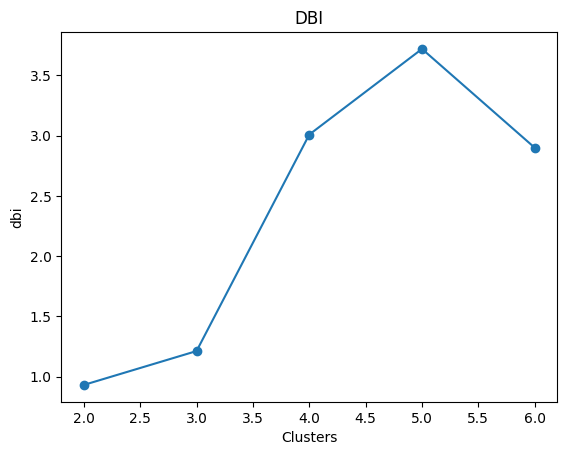

In [170]:
x = range(2, len(dbi_clusters) + 2)
plt.plot(x, dbi_clusters, marker='o')
plt.title('DBI')
plt.xlabel('Clusters')
plt.ylabel('dbi')
plt.show()

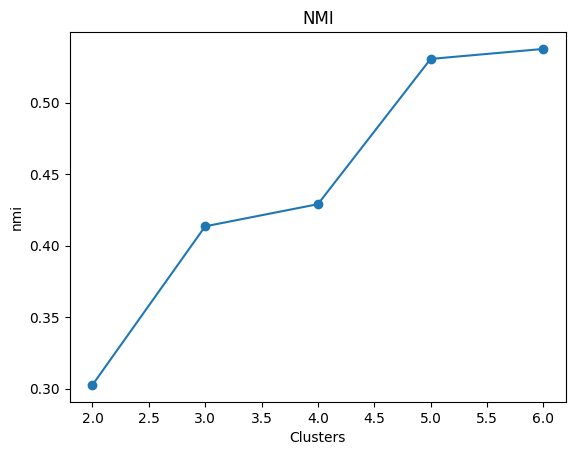

In [171]:
x = range(2, len(nmi_clusters) + 2)
plt.plot(x, nmi_clusters, marker='o')
plt.title('NMI')
plt.xlabel('Clusters')
plt.ylabel('nmi')
plt.show()

# Test

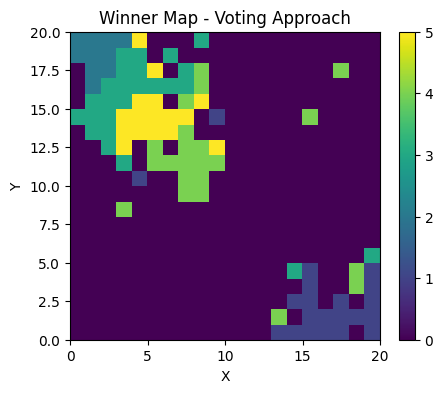

voting approach: 
Davies-Bouldin Index: 0.7168687606744458
Normalized Mutual Information: 0.7885107744820312


In [176]:
dim = (20, 20, y_train.shape[1])
neuron_labels = voting_approach(som_20x20, dim, X_test, y_test)
dbi_voting = test_clusters("voting approach: ", som_20x20, X_test, y_test, neuron_labels)

C:\Users\pars iran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


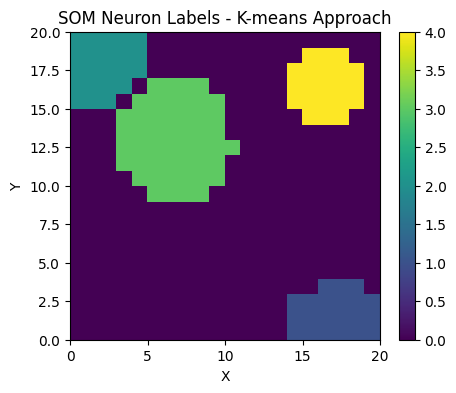

kmeans approach: 
Davies-Bouldin Index: 13.668776592531259
Normalized Mutual Information: 0.5291648427698934


In [178]:
neuron_labels = Kmeans_approach(som_20x20, y_test, 5)
dbi, nmi = test_clusters("kmeans approach: ", som_20x20, X_test, y_test, neuron_labels)